# Refression: what is this document's rate?

Objectivos:

        Evaluar la capacidad de un modelo de predecir el rate de una opinion.
        
        Rate: puntaje / vistas (signo refleja direccion, positiva o negativa, magnitud es el grado)

### Preprocess

In [1]:
path_to_MyModule = '..'

import sys
sys.path.insert(0, path_to_MyModule) 

import pandas as pd
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from MyModule.GeneralFunctions import *
from MyModule.SummarizationFunctions import *
from MyModule.SamplingFunctions import *

In [2]:
df = pd.read_excel('..\datos.xlsx')[['ID','texto','desafio','rate']]

In [3]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

df.reset_index(inplace=True, drop=True)

## Assign name "Target" to "rate"

In [4]:
df.rename({'rate':'target'}, axis=1, inplace=True)
df_predic = df.copy()
df_predic.drop('texto', axis=1, inplace=True)

# Feature engineering

## Sentence embedding feature

Create a sentence embedding for each document

Alternatives:

1. One column for each of the 768 D
2. Same but first reduce dimension with PCA or Lasso/Ridge

In [106]:
model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')

loading configuration file C:\Users\Felipe/.cache\torch\sentence_transformers\hiiamsid_sentence_similarity_spanish_es\config.json
Model config BertConfig {
  "_name_or_path": "C:\\Users\\Felipe/.cache\\torch\\sentence_transformers\\hiiamsid_sentence_similarity_spanish_es\\",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31002
}

loading weights file C:\Users\Felipe/.cache\torch\sentence_transformers\hiiamsid_sen

In [108]:
original_documents = df['texto'].values

pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

pp_documents = pp_object.preprocess(original_documents)

emb_docs = model.encode(pp_documents)

# Reduce dimensions
pca = PCA(n_components=300)
emb_docs_reduced = pca.fit_transform(emb_docs)

# Create df
df_emb = pd.DataFrame(emb_docs_reduced)
df_emb.columns = [f'doc_emb_dim_{i+1}' for i in range(len(emb_docs_reduced[0]))]

# Join with main df
df_predic = df_predic.join(df_emb)

## Sentiment Analysis feature

Evaluate positive, negative and neutral sentiment for each document

In [112]:
# Analyze the three sentiments for each doc
from MyModule.SentimentAnalysisFunctions import sentiment_analyzer_3d

all_emotions = {}
analyzer = sentiment_analyzer_3d()

for i, this_id in enumerate(df['ID'].values):
    all_emotions[this_id] = analyzer.predict_sentiment_3d(pp_documents[i])

loading configuration file config.json from cache at C:\Users\Felipe/.cache\huggingface\hub\models--pysentimiento--robertuito-sentiment-analysis\snapshots\12e030859ce19539e24b486ac84ffebb9b68ecf1\config.json
Model config RobertaConfig {
  "_name_or_path": "pysentimiento/robertuito-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type"

In [113]:
# Add as featrues the document vectors for each document in the pair
doc_pos = []
doc_neg = []
doc_neu = []

for id_text in df_predic['ID'].values:
    
    doc_pos.append(all_emotions[id_text][0])
    doc_neg.append(all_emotions[id_text][1])
    doc_neu.append(all_emotions[id_text][2])
    
df_predic['doc_pos'] = doc_pos
df_predic['first_doc_neg'] = doc_neg
df_predic['doc_neu'] = doc_neu

## Document's Length Feature

Compute document length 

In [114]:
all_lengths = {}

for i, this_id in enumerate(df['ID'].values):
    all_lengths[this_id] = len(df['texto'][i].split(' '))

In [115]:
doc_len = []

for id_text in df_predic['ID'].values:
    
    doc_len.append(all_lengths[id_text])

df_predic['doc_len'] = doc_len

## Checkpoint

In [5]:
#Save
# df_predic.to_csv('df_predic.csv', index=False)

# Load dfs
df_predic = pd.read_csv('df_predic.csv')

# Modeling

In [6]:
semilla = 2023

In [7]:
# Helpers

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def print_performance(y_val, y_pred, y_proba=None):

    # Calculate R-squared score
    r2 = r2_score(y_val, y_pred)
    print('R-squared score:', r2)
    
    # Calculate MSE
    mse = mean_squared_error(y_val, y_pred)
    print('Mean Squared Error:', mse)
    
    # Calculate MAE
    mae = mean_absolute_error(y_val, y_pred)
    print('Mean Absolute Error:', mae)

import pickle
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename): 
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

### Scaling

Since features have different scales

In [9]:
#Importamos StandardScaler de la libreria sklear
from sklearn.preprocessing import StandardScaler

# Instanciamos la funcion para escalar
scaler = StandardScaler()

#Escalamos las variables
scaled = scaler.fit_transform(df_predic.drop(['ID','desafio'], axis=1))
df_predic_scaled = pd.DataFrame(scaled, columns = df_predic.columns[2:])

### Train-test-validation split

In [10]:
from sklearn.model_selection import train_test_split

# Partición en train y test
y = df_predic_scaled.loc[:, df_predic_scaled.columns == 'target']['target'].values.tolist()
X = df_predic_scaled.loc[:, df_predic_scaled.columns != 'target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=semilla)

## 1. Linear Regression

### Simple Linear Regression

In [18]:
# instancia del modelo
linearRegr = LinearRegression()

# entrenamiento
linearRegr.fit(X_train, y_train)

# basic performance
y_pred = linearRegr.predict(X_val)

In [19]:
# Claramente las clases estan desbalanceadas
print_performance(y_val, y_pred)

R-squared score: -95.64821290668282
Mean Squared Error: 76.39024807506011
Mean Absolute Error: 6.731943560122277


## 2. SGDClassifier

In [159]:
#Importamos algunas funciones auxiliares
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

In [261]:
n_iter = 10000

model = SGDRegressor()

# Definimos los parametros
sgd_parametros = {
        'pca__n_components': range(50, X_train.shape[0]),
        'model__alpha': [0.0001, 0.001, 0.01, 0.1],
        'model__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'model__penalty': ['l2', 'l1', 'elasticnet'],
        'model__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
        'model__eta0': [0.01, 0.1, 1, 10],
        'model__epsilon': [0.1, 0.01, 0.001],
        'model__max_iter': [1000, 5000, 10000],
}

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
sgd_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=sgd_parametros,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=3
)

# fit the randomized search object to the data
sgd_random_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
16293 fits failed out of a total of 30000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
76 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model', SGDRegressor())]),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'model__alpha': [0.0001, 0.001, 0.01,
                                                         0.1],
                                        'model__epsilon': [0.1, 0.01, 0.001],
                                        'model__eta0': [0.01, 0.1, 1, 10],
                                        'model__learning_rate': ['constant',
                                                                 'optimal',
                                                                 'invscaling',
                                                                 'adaptive'],
                                        'model__loss': ['squared_loss', 'huber',
                                                        'epsilon_insensitive',
                                                        'squared_epsilon_insensitive'],
                                        'model__max_iter': [1000, 5000, 10000],
                                        'model__penalty': ['l2', 'l1',
                                                           'elasticnet'],
                                        'pca__n_components': range(50, 323)},
                   scoring='neg_mean_squared_error')

In [262]:
print('Mejor combinación de parámetros %s \n'% sgd_random_search.best_params_)
print('Definición del Modelo %s \n'% sgd_random_search.best_estimator_)
print('Combinaciones Evaluadas %s '% sgd_random_search)

Mejor combinación de parámetros {'pca__n_components': 125, 'model__penalty': 'elasticnet', 'model__max_iter': 1000, 'model__loss': 'huber', 'model__learning_rate': 'optimal', 'model__eta0': 1, 'model__epsilon': 0.001, 'model__alpha': 0.001} 

Definición del Modelo Pipeline(steps=[('pca', PCA(n_components=125)),
                ('model',
                 SGDRegressor(alpha=0.001, epsilon=0.001, eta0=1,
                              learning_rate='optimal', loss='huber',
                              penalty='elasticnet'))]) 

Combinaciones Evaluadas RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model', SGDRegressor())]),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'model__alpha': [0.0001, 0.001, 0.01,
                                                         0.1],
                                        'model__epsilon': [0.1, 0.01, 0.001],
                      

In [263]:
y_pred = sgd_random_search.best_estimator_.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.11971745731330918
Mean Squared Error: 0.6957707730913595
Mean Absolute Error: 0.686963562792037


## 3. KNN

### 3.1 Simple KNN

In [ ]:
# instanciemos y entrenemos el modelo
knn_model = KNeighborsRegressor(n_neighbors=10,weights='uniform')
knn_model.fit(X_train, y_train)


y_pred = knn_model.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.045816151225213986
Mean Squared Error: 0.7541819835561749
Mean Absolute Error: 0.6996676320965636


### 3.2 KNN Random Search

In [271]:
n_iter = 10000

model = KNeighborsRegressor()

# Definimos los parametros
param_distribution = {
        'pca__n_components': range(50, X_train.shape[0]),
        'model__n_neighbors': range(1, 21),
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [10, 20, 30, 40, 50],
        'model__p': [1, 2],
        'model__metric': ['euclidean', 'manhattan', 'minkowski']
}

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
knn_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distribution,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=3
)

# fit the randomized search object to the data
knn_random_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
11481 fits failed out of a total of 30000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
76 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model', KNeighborsRegressor())]),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'model__algorithm': ['ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                                        'model__leaf_size': [10, 20, 30, 40,
                                                             50],
                                        'model__metric': ['euclidean',
                                                          'manhattan',
                                                          'minkowski'],
                                        'model__n_neighbors': range(1, 21),
                                        'model__p': [1, 2],
                                        'model__weights': ['uniform',
                                                           'distance'],
                                        'pca__n_components': range(50, 323)},
                   scoring='neg_mean_squared_error')

In [273]:
print('Mejor combinación de parámetros %s \n'% knn_random_search.best_params_)
print('Definición del Modelo %s \n'% knn_random_search.best_estimator_)
print('Combinaciones Evaluadas %s '% knn_random_search)

Mejor combinación de parámetros {'pca__n_components': 126, 'model__weights': 'distance', 'model__p': 1, 'model__n_neighbors': 15, 'model__metric': 'euclidean', 'model__leaf_size': 20, 'model__algorithm': 'kd_tree'} 

Definición del Modelo Pipeline(steps=[('pca', PCA(n_components=126)),
                ('model',
                 KNeighborsRegressor(algorithm='kd_tree', leaf_size=20,
                                     metric='euclidean', n_neighbors=15, p=1,
                                     weights='distance'))]) 

Combinaciones Evaluadas RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model', KNeighborsRegressor())]),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'model__algorithm': ['ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                       

In [272]:
y_pred = knn_random_search.best_estimator_.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.05562825282001049
Mean Squared Error: 0.7464265491573215
Mean Absolute Error: 0.6992861927398882


## 4. DecisionTree

### 4.a Simple DecisionTree

In [269]:
from sklearn.tree import DecisionTreeRegressor

In [270]:
# instanciemos el modelo y entremoslo en el conjunto de autos
arbol = DecisionTreeRegressor()
arbol.fit(X_train, y_train)

y_pred = arbol.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: -0.7937140287064324
Mean Squared Error: 1.4177422997039748
Mean Absolute Error: 0.9382892644688998


### 4.b DecisionTree hyperparameter opt

In [275]:
n_iter = 10000

model = DecisionTreeRegressor()

# Definimos los parametros
param_distribution = {
        'pca__n_components': range(50, X_train.shape[0]),
        'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
        'model__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'model__min_samples_leaf': [1, 2, 3, 4, 5],
        'model__max_features': ['auto', 'sqrt', 'log2', None],
        'model__splitter': ['best', 'random'],
        'model__criterion': ['mse', 'friedman_mse', 'mae']
}

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
dt_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distribution,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=3
)

# fit the randomized search object to the data
dt_random_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
23885 fits failed out of a total of 30000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
82 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model',
                                              DecisionTreeRegressor())]),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'model__criterion': ['mse',
                                                             'friedman_mse',
                                                             'mae'],
                                        'model__max_depth': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, None],
                                        'model__max_features': ['auto', 'sqrt',
                                                                'log2', None],
                                        'model__min_samples_leaf': [1, 2, 3, 4,
                                                                    5],
                                        'model__min_samples_split': [2, 3, 4, 5,
                                                                     6, 7, 8, 9,
                                                                     10],
                                        'model__splitter': ['best', 'random'],
                                        'pca__n_components': range(50, 323)},
                   scoring='neg_mean_squared_error')

In [276]:
print('Mejor combinación de parámetros %s \n'% dt_random_search.best_params_)
print('Definición del Modelo %s \n'% dt_random_search.best_estimator_)
print('Combinaciones Evaluadas %s '% dt_random_search)

Mejor combinación de parámetros {'pca__n_components': 75, 'model__splitter': 'best', 'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_features': None, 'model__max_depth': 3, 'model__criterion': 'friedman_mse'} 

Definición del Modelo Pipeline(steps=[('pca', PCA(n_components=75)),
                ('model',
                 DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                                       min_samples_leaf=3))]) 

Combinaciones Evaluadas RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model',
                                              DecisionTreeRegressor())]),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'model__criterion': ['mse',
                                                             'friedman_mse',
                                                             'mae'],
                              

In [277]:
y_pred = dt_random_search.best_estimator_.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: -0.18281737195504832
Mean Squared Error: 0.9348927388691436
Mean Absolute Error: 0.7757095162367743


## 5. RandomForestClassifier

### 5.a Simple RandomForestClassifier

In [281]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train,y_train)

y_pred = rf_regressor.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.06529902620919759
Mean Squared Error: 0.7387828198419022
Mean Absolute Error: 0.6846766905797328


### 5.b RandomForestClassifier hyperparameter opt

In [283]:
n_iter = 10000

model = RandomForestRegressor()

# Definimos los parametros
param_distribution = {
        'pca__n_components': range(50, X_train.shape[0]),
        'model__n_estimators': [50, 100, 200, 300, 400, 500],
        'model__max_features': ['auto', 'sqrt', 'log2'],
        'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
        'model__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'model__min_samples_leaf': [1, 2, 3, 4, 5],
        'model__bootstrap': [True, False],
        'model__criterion': ['absolute_error', 'poisson', 'squared_error', 'friedman_mse']
}

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
rf_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distribution,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=3
)

# fit the randomized search object to the data
rf_random_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
16131 fits failed out of a total of 30000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
66 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__criterion': ['absolute_error',
                                                             'poisson',
                                                             'squared_error',
                                                             'friedman_mse'],
                                        'model__max_depth': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, None],
                                        'model__max_features': ['auto', 'sqrt',
                                                                'log2'],
                                        'model__min_samples_leaf': [1, 2, 3, 4,
                                                                    5],
                                        'model__min_samples_split': [2, 3, 4, 5,
                                                                     6, 7, 8, 9,
                                                                     10],
                                        'model__n_estimators': [50, 100, 200,
                                                                300, 400, 500],
                                        'pca__n_components': range(50, 323)},
                   scoring='neg_mean_squared_error')

In [284]:
print('Mejor combinación de parámetros %s \n'% rf_random_search.best_params_)
print('Definición del Modelo %s \n'% rf_random_search.best_estimator_)
print('Combinaciones Evaluadas %s '% rf_random_search)

Mejor combinación de parámetros {'pca__n_components': 173, 'model__n_estimators': 50, 'model__min_samples_split': 6, 'model__min_samples_leaf': 5, 'model__max_features': 'auto', 'model__max_depth': None, 'model__criterion': 'squared_error', 'model__bootstrap': True} 

Definición del Modelo Pipeline(steps=[('pca', PCA(n_components=173)),
                ('model',
                 RandomForestRegressor(max_features='auto', min_samples_leaf=5,
                                       min_samples_split=6, n_estimators=50))]) 

Combinaciones Evaluadas RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__criterion': ['absolute_error',
                                    

In [285]:
y_pred = rf_random_search.best_estimator_.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.07648396740808006
Mean Squared Error: 0.7299423001137975
Mean Absolute Error: 0.6796525722853731


## 6. Bagging

### 6.a Simple Bagging ExtraTrees

In [30]:
dt_bagging = BaggingRegressor(ExtraTreesRegressor())

dt_bagging.fit(X_train,y_train)

R-squared score: 0.12852391278636455
Mean Squared Error: 0.688810196190696
Mean Absolute Error: 0.6665869208492625


In [31]:
y_pred = dt_bagging.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.12852391278636455
Mean Squared Error: 0.688810196190696
Mean Absolute Error: 0.6665869208492625


## 6.b Bagging huge hyperparameter opt

In [60]:
n_iter = 1000

pca_hyperparameters = {
    'pca__n_components': range(50, X_train.shape[0]),
}

bagging_hyperparameters = {
    'model__bootstrap': [True, False],
    'model__n_estimators': randint(10, 100),
    'model__max_samples': [0.5, 0.7, 0.9],
    'model__base_estimator': [DecisionTreeRegressor(), RandomForestRegressor(), ExtraTreesRegressor()], 
}

base_hyperparameters = {
    'model__base_estimator__max_depth': randint(3, 10),
    'model__base_estimator__max_features': ['auto', 'sqrt', 'log2', None],
    'model__base_estimator__min_samples_split': [2, 5, 10],
    'model__base_estimator__min_samples_leaf': [1, 2, 4], 
}


# define parameter distribution for random search
param_distributions = {
    
    **pca_hyperparameters,
    **bagging_hyperparameters,
    **base_hyperparameters
    
}

# create a bagging regressor with a random base model
model = BaggingRegressor(random_state=semilla, base_estimator=None)

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
bagging_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=1000,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=semilla
)

# fit the model with training data
bagging_random_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1217 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Fe

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model',
                                              BaggingRegressor(base_estimator=None,
                                                               random_state=2023))]),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'model__base_estimator': [DecisionTreeRegressor(),
                                                                  RandomForestRegressor(),
                                                                  ExtraTreesRegressor(max_depth=9,
                                                                                      max_features='auto',
                                                                                      min_samples_leaf=4,
                                                                                      min_samples_split=5)],
                                        'model__b...
                                        'model__base_estimator__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4],
                                        'model__base_estimator__min_samples_split': [2,
                                                                                     5,
                                                                                     10],
                                        'model__bootstrap': [True, False],
                                        'model__max_samples': [0.5, 0.7, 0.9],
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000241FE69E4C0>,
                                        'pca__n_components': range(50, 323)},
                   random_state=2023, scoring='neg_mean_squared_error')

In [79]:
y_pred = bagging_random_search.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.11830544329113979
Mean Squared Error: 0.6968868216782396
Mean Absolute Error: 0.6645392639518722


## 7. ExtraTrees

### 7.a Simple ExtraTrees

In [21]:
extra_trees = ExtraTreesRegressor()
extra_trees.fit(X_train,y_train)

ExtraTreesRegressor()

In [22]:
y_pred = extra_trees.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.08093224269983745
Mean Squared Error: 0.7264264063085847
Mean Absolute Error: 0.6791160813959356


### 7.b ExtraTrees hyperparameter opt

In [34]:
n_iter = 1000

model = ExtraTreesRegressor()

# Definimos los parametros
param_distribution = {
        'pca__n_components': range(50, X_train.shape[0]),
        'model__n_estimators': [50, 100, 200, 500],
        'model__criterion': ['squared_error', 'absolute_error'],
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['auto', 'sqrt', 'log2', None]
}

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
et_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distribution,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=3
)

# fit the randomized search object to the data
%time et_random_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [29]:
y_pred = et_random_search.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.04983471035345677
Mean Squared Error: 0.7510057351861491
Mean Absolute Error: 0.6982393586224803


## 8. AdaBoost

### 8.a Simple AdaBoost

In [11]:
adaboost_reg = AdaBoostRegressor(base_estimator=ExtraTreesRegressor(random_state=semilla), n_estimators=100)

adaboost_reg.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostRegressor(base_estimator=ExtraTreesRegressor(random_state=2023),
                  n_estimators=100)

In [12]:
y_pred = adaboost_reg.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.10050160215258996
Mean Squared Error: 0.7109588857170847
Mean Absolute Error: 0.6666021693205163


### 8.b AdaBoost Hyperparameter opt

In [12]:
n_iter = 100

# create a AdaBoostRegressor with a random base model
model = AdaBoostRegressor(random_state=semilla)
model.base_estimator = ExtraTreesRegressor()

# define parameter distribution for random search
param_distributions = {
    'pca__n_components': range(50, X_train.shape[0]),
    'model__n_estimators': randint(low=50, high=200),
    'model__learning_rate': uniform(0.01, 1),
    'model__loss': ['linear', 'square', 'exponential', 'huber', 'quantile'],
    'model__base_estimator': [ExtraTreesRegressor(random_state=semilla), RandomForestRegressor(random_state=semilla), GradientBoostingRegressor(random_state=semilla), SVR()],
}

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
ab_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=3
)

# fit the randomized search object to the data
ab_random_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Felipe\miniconda

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model',
                                              AdaBoostRegressor(base_estimator=ExtraTreesRegressor(),
                                                                random_state=2023))]),
                   n_iter=100,
                   param_distributions={'model__base_estimator': [ExtraTreesRegressor(random_state=2023),
                                                                  RandomForestRegressor(random_state=2023),
                                                                  GradientBoostingRegressor(random_state=2023),
                                                                  SVR()],
                                        'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C07B9FDE80>,
                                        'model__loss': ['linear', 'square',
                                                        'exponential', 'huber',
                                                        'quantile'],
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C017B647C0>,
                                        'pca__n_components': range(50, 323)},
                   scoring='neg_mean_squared_error')

In [13]:
y_pred = ab_random_search.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.07360556463057422
Mean Squared Error: 0.7322173747956845
Mean Absolute Error: 0.6789041536763046


## 9. GradientBoosting

### 9.a Simple GradientBoosting

In [21]:
grad_boost_reg = GradientBoostingRegressor()

grad_boost_reg.fit(X_train,y_train)

GradientBoostingRegressor()

In [22]:
y_pred = grad_boost_reg.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: -0.032489600130464646
Mean Squared Error: 0.8160744448015772
Mean Absolute Error: 0.7198940025173418


## 9. XGBoost

### 9.a Simple XGBoost

In [66]:
xgb = XGBRegressor(eval_metric="logloss", use_label_encoder=False)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='logloss',
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [67]:
y_pred = xgb.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: -0.009301756709540143
Mean Squared Error: 0.7977468931792794
Mean Absolute Error: 0.7155411929854604


### 9.b XGBooost Hyperparameter opt

In [14]:
n_iter = 100

model = XGBRegressor()

# Definimos los parametros
param_distribution = {
    'pca__n_components': range(50, X_train.shape[0]),
    'model__max_depth': randint(1, 10),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__n_estimators': randint(50, 1000),
    'model__min_child_weight': randint(1, 10),
    'model__subsample': uniform(0.5, 0.5),
    'model__colsample_bytree': uniform(0.5, 0.5),
    'model__gamma': uniform(0, 0.5),
    'model__reg_alpha': uniform(0,0.5),
    'model__reg_lambda': uniform(0, 0.5),
}

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
xgb_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distribution,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=3
)

# fit the randomized search object to the data
xgb_random_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
131 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Feli

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           inte...
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C017B64D60>,
                                        'model__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C0181AD430>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C017A9E7F0>,
                                        'pca__n_components': range(50, 323)},
                   scoring='neg_mean_squared_error')

In [15]:
y_pred = xgb_random_search.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.05220488588146044
Mean Squared Error: 0.7491323606961267
Mean Absolute Error: 0.6785912639273348


## 10. LightGBM

### 10.a LightGBM Hyperparameter Optimization

In [16]:
n_iter = 100

model = LGBMRegressor()

# Definimos los parametros
param_distribution = {
    'pca__n_components': range(50, X_train.shape[0]),
    'model__boosting_type': ['gbdt', 'dart'],
    'model__num_leaves': randint(10, 100),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__subsample': uniform(0.5, 0.5),
    'model__colsample_bytree': uniform(0.5, 0.5),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0, 1),
    'model__n_estimators': [100, 500, 1000],
    'model__max_depth': [3, 5, 10, -1]
}

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
lgbm_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distribution,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=3
)

# fit the randomized search object to the data
lgbm_random_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Feli

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model', LGBMRegressor())]),
                   n_iter=100,
                   param_distributions={'model__boosting_type': ['gbdt',
                                                                 'dart'],
                                        'model__colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C0181D0F10>,
                                        'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen...
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C01A3B53D0>,
                                        'model__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C0181D0670>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C07B460610>,
                                        'pca__n_components': range(50, 323)},
                   scoring='neg_mean_squared_error')

In [17]:
y_pred = lgbm_random_search.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: -0.033639072059190145
Mean Squared Error: 0.8169829814744224
Mean Absolute Error: 0.7343364208862077


## 11. CatBoost

### 11.a Simple CatBoost

In [18]:
catb = CatBoostRegressor()
catb.fit(X_train,y_train)

Learning rate set to 0.034248
0:	learn: 1.0033353	total: 182ms	remaining: 3m 1s
1:	learn: 0.9979619	total: 219ms	remaining: 1m 49s
2:	learn: 0.9937704	total: 257ms	remaining: 1m 25s
3:	learn: 0.9868736	total: 295ms	remaining: 1m 13s
4:	learn: 0.9810415	total: 333ms	remaining: 1m 6s
5:	learn: 0.9737324	total: 372ms	remaining: 1m 1s
6:	learn: 0.9681300	total: 412ms	remaining: 58.4s
7:	learn: 0.9618650	total: 451ms	remaining: 55.9s
8:	learn: 0.9565516	total: 489ms	remaining: 53.9s
9:	learn: 0.9525337	total: 528ms	remaining: 52.2s
10:	learn: 0.9499117	total: 567ms	remaining: 51s
11:	learn: 0.9427279	total: 605ms	remaining: 49.8s
12:	learn: 0.9377881	total: 643ms	remaining: 48.8s
13:	learn: 0.9330523	total: 681ms	remaining: 48s
14:	learn: 0.9265888	total: 719ms	remaining: 47.2s
15:	learn: 0.9203770	total: 760ms	remaining: 46.7s
16:	learn: 0.9138501	total: 798ms	remaining: 46.1s
17:	learn: 0.9113077	total: 836ms	remaining: 45.6s
18:	learn: 0.9049863	total: 874ms	remaining: 45.1s
19:	learn: 0

In [19]:
y_pred = catb.predict(X_val)
print_performance(y_val, y_pred)

R-squared score: 0.09591586532212182
Mean Squared Error: 0.7145834284121951
Mean Absolute Error: 0.6811911619921868


## 11.b CatBoost hyperparameter opt

In [20]:
n_iter = 100

model = CatBoostRegressor()

# Definimos los parametros
param_distribution = {
        'pca__n_components': range(50, X_train.shape[0]),
        'model__iterations': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__depth': randint(3, 10),
        'model__l2_leaf_reg': uniform(0.1, 10),
        'model__bagging_temperature': uniform(0, 1),
        'model__random_strength': uniform(0, 1),
        'model__scale_pos_weight': uniform(0.1, 10),
        'model__eval_metric': ['RMSE', 'MAE', 'R2'],
        'model__od_type': ['IncToDec', 'Iter'],
        'model__od_wait': randint(10, 50)
}

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
catboost_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distribution,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=3
)

# fit the randomized search object to the data
catboost_random_search.fit(X_train, y_train)

ValueError: 
All the 300 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
186 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\catboost\core.py", line 5726, in fit
    _process_synonyms(params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\catboost\core.py", line 1558, in _process_synonyms
    raise CatBoostError('scale_pos_weight is supported only for binary classification Logloss loss')
_catboost.CatBoostError: scale_pos_weight is supported only for binary classification Logloss loss

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=301 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=301 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=224 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=224 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=313 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=313 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=273 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=273 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=253 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=253 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=315 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=315 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=275 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=275 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=219 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=219 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=270 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=270 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=307 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=307 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=296 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=296 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=276 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=276 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=274 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=274 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=221 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=221 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=310 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=310 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=244 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=244 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=322 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=322 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=241 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=241 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=220 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=220 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=312 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=312 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=281 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=281 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=227 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=227 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=245 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=245 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=254 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=254 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=247 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=247 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=252 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=252 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=236 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=236 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=268 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=268 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=294 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=294 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=304 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=304 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=237 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=237 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=231 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=231 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=261 must be between 0 and min(n_samples, n_features)=215 with svd_solver='full'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 512, in _fit
    return self._fit_full(X, n_components)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py", line 526, in _fit_full
    raise ValueError(
ValueError: n_components=261 must be between 0 and min(n_samples, n_features)=216 with svd_solver='full'


In [ ]:
y_pred = catboost_random_search.predict(X_val)
print_performance(y_val, y_pred)

NameError: name 'catb_randomized_search' is not defined

# 12. Support Vector Machines 

### 12.a Simple SVM

In [ ]:
svm_regressor = SVR(kernel='linear')
svm_regressor.fit(X_train,y_train)

In [ ]:
y_pred = svm_regressor.predict(X_val)
print_performance(y_val, y_pred)

### 12.b SVM Random Search Hyperparameter Opt

In [ ]:
n_iter = 100

model = SVR()

# Definimos los parametros
param_distribution = {
        'pca__n_components': range(50, X_train.shape[0]),
        'model__kernel': ['linear', 'rbf', 'poly'],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto'] + list(np.logspace(-5, 2, 8)),
        'model__degree': [2, 3, 4],
        'model__epsilon': [0.01, 0.1, 1, 10, 100],
        'model__max_iter': [100, 500, 1000, 5000, 10000],
}

# create the pipeline object with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('model', model)
])

# create the randomized search object
svm_random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distribution,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=3
)

# fit the randomized search object to the data
svm_random_search.fit(X_train, y_train)

In [ ]:
y_pred = svm_random_search.predict(X_val)
print_performance(y_val, y_pred)

# Evaluating the model for each desafio

In [13]:
# Partición en train y test
y = df_predic_scaled.loc[:, df_predic_scaled.columns == 'target']['target'].values.tolist()
X = df_predic_scaled.loc[:, df_predic_scaled.columns != 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)


Desafio: 15
Accuracy: 0.974530
Precision: 0.868957
Recall: 0.994178
F1 score: 0.927359
AUC: 0.982433


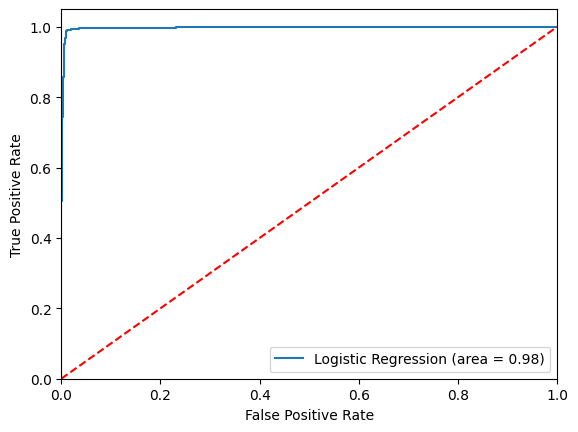


Desafio: 13
Accuracy: 0.966271
Precision: 0.853568
Recall: 0.998915
F1 score: 0.920540
AUC: 0.978624


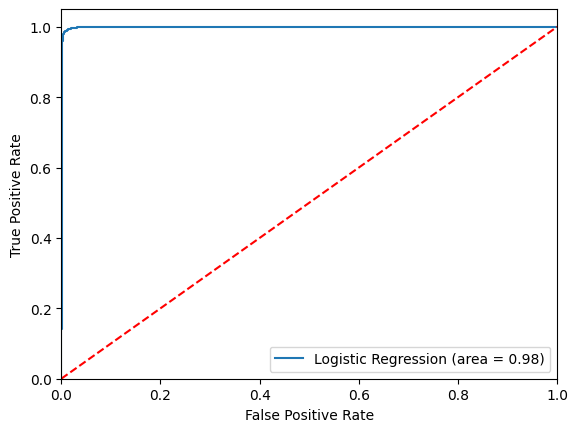


Desafio: 14
Accuracy: 0.991778
Precision: 0.937500
Recall: 0.997625
F1 score: 0.966628
AUC: 0.994305


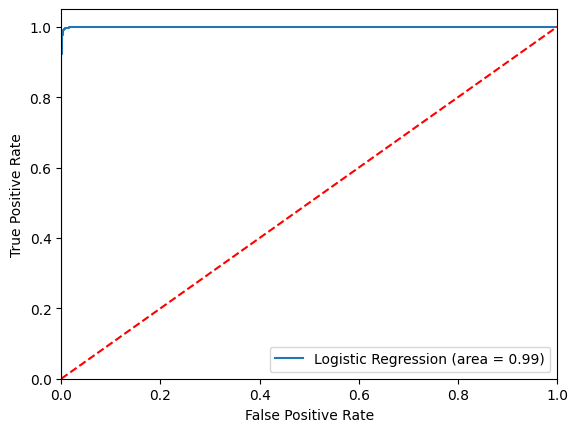


Desafio: 12
Accuracy: 0.933014
Precision: 0.661829
Recall: 0.989154
F1 score: 0.793043
AUC: 0.956899


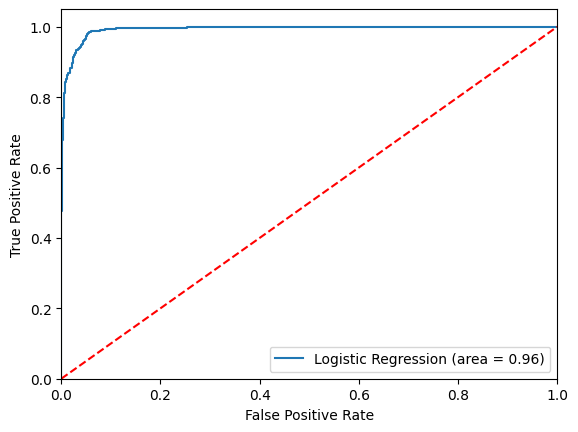


Desafio: 16
Accuracy: 0.961609
Precision: 0.804775
Recall: 0.987931
F1 score: 0.886997
AUC: 0.972402


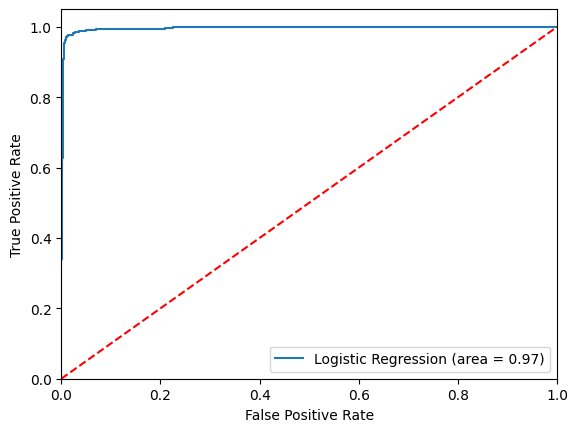


Desafio: 17
Accuracy: 0.949730
Precision: 0.676087
Recall: 1.000000
F1 score: 0.806744
AUC: 0.971919


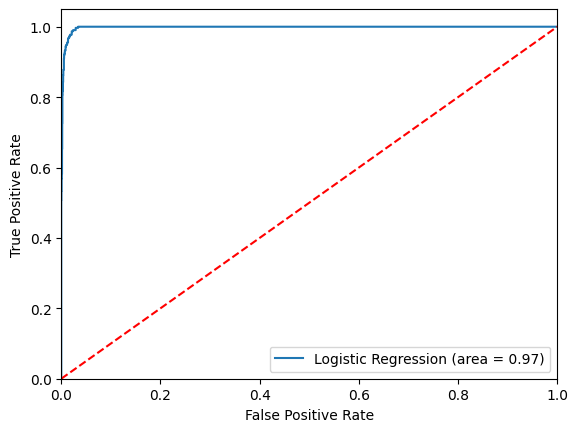


Desafio: 18
Accuracy: 0.929740
Precision: 0.633858
Recall: 0.990769
F1 score: 0.773109
AUC: 0.956061


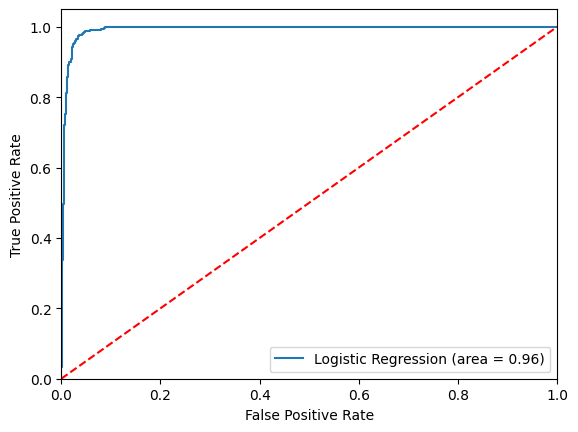

In [14]:
for des in df.desafio.unique():
    
    print(f'\nDesafio: {des}')
    
    indices_des = [i for i,x in enumerate(X_test['id_pairs'].values) if x[0] in df[df['desafio']==des]['ID'].values]

    X_test_des = X_test.iloc[indices_des].drop('id_pairs', axis=1)

    y_test_des = [x for i,x in enumerate(y_test) if i in indices_des]
    
    y_pred = xgb_cls.predict(X_test_des)
    y_pred_proba = xgb_cls.predict_proba(X_test_des)
    print_performance(y_test_des, y_pred, y_pred_proba)